# Lab 2: Uncertainty Quantification for Large Language Models

Prepared by Roman Vashurin

## !!! Important !!!

#### If you are trying to run this on Windows

Please don't.

#### Linux & MacOS

Before running this notebook make sure to create a fresh conda environment with Python 3.10 and activate it like so:

```
$ conda create -n llm_ue_lab python==3.10
$ conda activate llm_ue_lab
$ pip install jupyterlab
```

Then restart the jupyter lab in this environment.

If you don't have conda installed, do it like this (assuming you are using bash as your shell):
```
$ cd ~
$ wget https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh
$ bash ~/miniconda3/miniconda.sh -b -u -p ~/miniconda3
$ ~/miniconda3/bin/conda init bash
$ source .bashrc
```
And run the commands in the beginning of this cell.

## Install the required libraries, import everything we need and set some hyperparameters

In [ ]:
# Install the LM-polygraph
!git clone https://github.com/IINemo/lm-polygraph.git
!cd lm-polygraph
!pip install ./lm-polygraph

# Install some additional stuff
!pip install seaborn

In [ ]:
import transformers
from transformers import AutoModelForCausalLM, AutoTokenizer
from datasets import load_dataset
from tqdm import tqdm

import torch
import numpy as np
import pprint
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

pp = pprint.PrettyPrinter(indent=4)

In [ ]:
N_SHOT=5
N_EXAMPLES=100
DEVICE='cuda:0'

## Set the seed

In [ ]:
def seed_everything(seed: int) -> None:
    import random, os
    import numpy as np
    import torch
    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
seed_everything(1)

## Load and set up the model
We will use a instruct-finetuned Qwen2-1.5B. Loading the model might take some time, please be patient

In [ ]:
model_name = 'Qwen/Qwen2-1.5B-Instruct'

# Load model and tokenizer
model = AutoModelForCausalLM.from_pretrained(model_name, device_map=DEVICE)
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Suppress some annoying warnings
model.generation_config.pad_token_id = tokenizer.eos_token_id
tokenizer.pad_token_id = tokenizer.eos_token_id

## Prepare data

We will use TriviaQA dataset - its validation split in particular.

It contains a huge number of quiz questions with answers.

We will select 100 questions randomly, with 5 more as few-shot examples.

Sit tight, this might take a while.

In [ ]:
dataset = load_dataset('trivia_qa', 'rc.nocontext')['validation']
sample_ids = np.random.choice(range(len(dataset)), N_SHOT+N_EXAMPLES, replace=False)
dataset = dataset.select(sample_ids)

Here's how the single element of the dataset looks:

In [ ]:
pp.pprint(dataset[0])

We will use `question` field as the basis for our input prompt, and `normalized_value` field of the `answer` sub-dict as a reference to score the model's answer. Let's extract them and start building our dataset.

In [ ]:
answers = [a['normalized_value'] for a in dataset['answer']]
questions = dataset['question']
qa_pairs = list(zip(questions, answers))

print(qa_pairs[0])
print()
print('Number of questions: ', len(qa_pairs))

Now let's separate few shot examples from the actual data. First `N_EXAMPLES` are our test points, while remaining `N_SHOT` are few shot questions.

In [ ]:
few_shot_data = qa_pairs[N_EXAMPLES:]
test_data = qa_pairs[:N_EXAMPLES]

print('Number of few-shot examples: ', len(few_shot_data))
print('Number of actual data points: ', len(test_data))

Instruct-finetuned models need instructions to work (duh), just giving them question will not be optimal use of their capabilities. Let's wrap our data in some nice prompt.

We will start with the basic description of the task. We will need to score model's output against the reference answers, so we better instruct the model to be brief and on-point with its answers.

In [ ]:
prompt = "The following are some trivia questions with answers. Please answer the last one in the same format, by providing only the answer itself, with NO explanation or introduction of any kind, or repeating the quesiton itself."

print(prompt)

Now, let's present the model with some examples that show the format of questions and answers that it is expected to follow when producing its answers. This is called few-shot evaluation.

In [ ]:
few_shot_prompt = "Question:{question}\nAnswer:{answer}"

prompt += "\n\nHere are some examples:\n\n"
prompt += "\n\n".join([few_shot_prompt.format(question=q, answer=a) for q, a in few_shot_data])
prompt += "\n\nNow answer the following question in the same format.\n\n"

print(prompt)

Alright, now let's use this as the base, and wrap every question in our dataset in it:

In [ ]:
test_prompts = []
test_answers = []

for q, a in test_data:
    full_prompt = prompt + "Question:{question}\nAnswer:".format(question=q)
    test_prompts.append(full_prompt)
    test_answers.append(a)

print(test_prompts[0])

And that is not all. Instruct-finetuned (or "chat") models are trained with inputs formatted in a specific way. Usually this is some form of markup, that allows the model to distinguish between what user said, and its previous responses in the continous dialogue with the user. These templates differ from model to model, but these days they are conveniently available as a tokenizer function. Let's take a look at what it does. But first we need to wrap our prompts in a list of dicts, which is an expected format for the tokenizer when applying chat templates.

In [ ]:
chat = [{'role':'user', 'content': test_prompts[0]}]
chat = tokenizer.apply_chat_template(chat, tokenize=False, add_generation_prompt=True)

print(chat)

You can see that some additional sequences of symbols appeared in the prompt. This is the markup that allows the model to make sense of the dialogue. While our interaction with the model will be limited to one request, and this might seem redundant, we need to keep in mind that chat models are trained with inputs formatted in such way. Thus, while model will not throw an error or otherwise complain if such template is not applied to the input sequences, its performance might be severely degraded.

So let's implement the function that applies this template to all our test inputs, and tokenizes the result so we can pass it's output directly to the model for generation.

In [ ]:
def chatify_and_tokenize(raw_prompt):
    chat = [{'role':'user', 'content': raw_prompt}]
    chat = tokenizer.apply_chat_template(chat, tokenize=False, add_generation_prompt=True)
    return tokenizer(chat, return_tensors='pt').to(DEVICE)

We instructed the tokenizer to return PyTorch tensors after tokenization, and put resulting tensors on the same device as the model, so we can now directly feed it's output to the model's `generate` function. Let's ask the model some questions now.

## Model Evaluation

In [ ]:
inputs = []
outputs = []

for raw_prompt in tqdm(test_prompts):
    input = chatify_and_tokenize(raw_prompt)
    inputs.append(input)
    outputs.append(model.generate(**input, max_new_tokens=20))

Let's take a look at how the decoded model's output looks like.

In [ ]:
print(outputs[0])

Yeah, we're not in the Matrix movie, we can't make sense of that. Let's decode this back into the word space.

In [ ]:
print(tokenizer.batch_decode(outputs[0])[0])

Much better, but that's still a mess. We get the whole input prompt, all the special tags of chat template, and only then we see the actual answer to the question. To be able to score this answer against the reference from the dataset, we need to somehow extract it from the resulting output.

Let's start with removing the whole input sequence. For each of the input sequences, we know its length in tokens. So if we remove the same number of tokens from the beginning of the models output before decoding it, we can expect that the input sequence will be gone. Let's check if this is true on one example.

In [ ]:
input_length = inputs[0]['input_ids'].shape[1] # Each input is a tensor of shape [batch_size, sequence_length]
out = outputs[0][:, input_length:] # Only take tokens starting with position after input_length.

print(out)
print(tokenizer.batch_decode(out))

Now we're talking. But we still have chat template tag left. Let's remove it by instructing tokenizer to not include special tokens into decoded text.

In [ ]:
print(tokenizer.batch_decode(out, skip_special_tokens=True))

Perfect. Let's make this into a function to process the rest of the model's responses. While we're at it, we can also normalize the output - make it lowercase, and remove any whitespaces on the sides of the sequence.

In [ ]:
def extract_answer(input, output):
    input_length = input['input_ids'].shape[1]
    out = output[:, input_length:]
    decoded = tokenizer.batch_decode(out, skip_special_tokens=True)

    return decoded[0].strip().lower() # We assume batch size is 1

Let's process the generated outputs and take a look how good the model is in terms of accuracy (exact match).

In [ ]:
generated_answers = np.array([extract_answer(inp, out) for inp, out in zip(inputs, outputs)])

print(generated_answers[0])

In [ ]:
pointwise_accuracy = (generated_answers == test_answers).astype(int)

print(pointwise_accuracy)

In [ ]:
mean_accuracy = pointwise_accuracy.mean()

print(mean_accuracy)

0.23 - not great. Let's try to improve this by sacrificing some coverage.

## Sequence Level Uncertainty Estimation

While estimating uncertainty for the whole generated sequence might not be a best idea when longer generations are present, we are concered here with fairly short answers to trivia questions, so it's actually relevant. We will use LM-Polygraph library as the reference implementation of many UE techniques for LLMs. Let's set up the function that will output uncertainties for out data.

In [ ]:
from lm_polygraph.utils.manager import UEManager
from lm_polygraph.utils.dataset import Dataset
from lm_polygraph.utils.model import WhiteboxModel
from lm_polygraph.ue_metrics.pred_rej_area import PredictionRejectionArea
from lm_polygraph.ue_metrics.ue_metric import (normalize_metric, get_random_scores)
from lm_polygraph.estimators import *

wb_model = WhiteboxModel(model, tokenizer, model_name, 'CausalLM')

def estimate_uncertainty(prompts, targets, estimator):
    man = UEManager(
        Dataset(prompts, targets, batch_size=1),
        wb_model,
        [estimator],
        [],
        [],
        [],
        ignore_exceptions=False,
        verbose=True,
    )
    man()
    ue_values = man.estimations[('sequence', str(estimator))]

    return np.array(ue_values)

### Maximum Sequence Probability

Recall from the lecture, that the model assigns probability to each generated sequence by multiplying probabilities of each token in that sequence. We can interpret the probability of the returned sequence as the measure of uncertainty. If the probability of output when answering question Q1 is higher than the probability when answering question Q2, we assume the model was less certain when answering Q2. So the resulting estimate is as such:

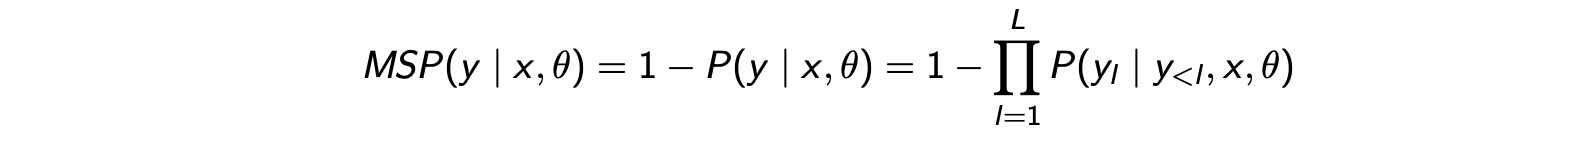

Since multiplying small number many times is a really bad idea from computational perspective, we will instead use log-probabilities. Or rather Polygraph will. Let's calculate MSP estimates for out data.

BTW we don't use chat templates here, since LM-Polygraph knows how to handle them already.

In [ ]:
estimator = MaximumSequenceProbability()

msp_ue = estimate_uncertainty(test_prompts, test_answers, estimator)

We want to use uncertainty values to figure out which answers are likely to be correct, and which are probably not. Let's take a look at distributions of UE values for correct and incorrect answers.

In [ ]:
correct_response_ids = np.argwhere(np.array(pointwise_accuracy) == 1).flatten()

correct_ues = msp_ue[correct_response_ids]
incorrect_ues = msp_ue[list(set(range(100)) - set(correct_response_ids))]

sns.histplot(correct_ues, bins=100, binrange=(0,1), label='Correct')
sns.histplot(incorrect_ues, bins=100, binrange=(0,1), label='Incorrect')
plt.legend(labels=['Correct', 'Incorrect'])

Not particularly insightful. Other ideas?

We have two classes - Correct and Incorrect, and a predictor variable - uncertainty of generation. Can we look at this as a binary classification problem? Let's calculate some AUROC.

In [ ]:
score = roc_auc_score(pointwise_accuracy, -msp_ue) # Negate the uncertainty values, since sklearn expects higher values of predictor to correspond to higher values of the response variable

print(score)

Not bad. But not very interpretable. And what if don't use binary metric like accuracy? Like Rouge-L for example. Can we come up with a better evaluation approach to uncertainty estimation techniques?

In fact, yes. Enter rejection curves.

To plot a rejection curve, we first sort the values of pointwise accuracy (i.e. 0/1 indicators whether the answer was correct) in the order of increasing corresponding uncertainty:

In [ ]:
sorted_accuracy = pointwise_accuracy[np.argsort(msp_ue)]

print(sorted_accuracy)

Now, numbers in the beginning of this array correspond to answers with lower uncertainty, while those closer to the end - to answers with higher uncertainty. We can start throwing away points with high uncertainty (from the end of the array) and calculate average accuracy among the remainging points (with lower uncertainty). Let's see what this gets us.

In [ ]:
sorted_accuracy_cumulative = np.cumsum(sorted_accuracy) # number of correct predictions in each subset of the data
num_remaining_points = np.arange(1, N_EXAMPLES + 1) # total number of points in each subset

rejected_accuracy = sorted_accuracy_cumulative / num_remaining_points

print('Number of correct predictions in subset')
print(sorted_accuracy_cumulative)
print('='*100)
print('Total number of predictions in subset')
print(num_remaining_points)
print('='*100)
print('Average accuracy')
print(rejected_accuracy)

Already from the numbers we can see there's a trend here. Currently we ordered the accuracy after rejection so it starts with small subsets of very confident predictions, and builds up to full coverage where all points are considered. Usually these curves are built other way around - with reducing coverage from left to right (or increasing rejection rate). Let's flip it and plot it.

In [ ]:
rejected_accuracy = np.flip(rejected_accuracy)
rejection_rates = np.linspace(0, 1, N_EXAMPLES)

In [ ]:
g = sns.lineplot(x=rejection_rates, y=rejected_accuracy)
g.set_xlabel('Rejection rate')
g.set_ylabel('Average accuracy')
g.grid()

This is what we expect from the valid uncertainty estimates: when high-uncertainty data is continuously removed, remaining predictions are expected to be, on average, better - i.e. the curve has an increasing trend.

Now looking at this curve we can make the following claim: if we reduce coverage to 50% (i.e. remove 50% of inputs with lowest uncertainty calculated via MSP), we can expect average accuracy of our model to increase from ~0.21 to 0.4+. This is much more interpretable result than before. 

Can we somehow summarize how 'good' this curve is in one number? Maybe calculate area under it? The problem here is that area under this curve will depend on the starting point - base accuracy of out model.

But we can compare it to the worst and best cases. Worst case is completely useless UE, one that does correlate with accuracy. We can simulate such UE by shuffling accuracy randomly pretending we did this using some very bad UE. Best case is UE which perfectly correlates with accuracy. We call this an oracle, and simulate such UE by just sorting accuracy directly. 

Let's write a function that will produce rejection curves for our uncertainty estimates, oracle and random now.

In [ ]:
def get_ue_rejection(ue, acc, num_remaining_points):
    return np.flip(np.cumsum(acc[np.argsort(ue)]) / num_remaining_points)
    
def get_oracle_rejection(ue, acc, num_remaining_points):
    return np.flip(np.cumsum(np.flip(np.sort(acc))) / num_remaining_points) # Note, that to obtain oracle curve, instead of using UE values to order accuracy array, we just directly sort it. This corresponds to perfect UE - one that correctly predicts accuracy 100% of time.
    
def get_random_rejection(ue, acc, num_remaining_points):
    random_rejection_accuracies = []
    for _ in range(1000):
        order = np.arange(0, N_EXAMPLES)
        np.random.shuffle(order)
        random_rejection_accuracies.append(np.flip(np.cumsum(acc[order]) / num_remaining_points)) # In the same fashion we now use random order of accuracy array to simulate uninformative UE, and then repeat and average over many runs to smoothen the resulting curve.

    return np.mean(random_rejection_accuracies, axis=0)

def plot_rejection_curves(ue, acc):
    ue_rejected_accuracy = get_ue_rejection(ue, acc, num_remaining_points)
    
    oracle_rejected_accuracy = get_oracle_rejection(ue, acc, num_remaining_points)

    random_rejection_accuracy = get_random_rejection(ue, acc, num_remaining_points)
    
    rejection_rates = np.linspace(0, 1, N_EXAMPLES)

    sns.lineplot(x=rejection_rates, y=ue_rejected_accuracy, label='UE')
    sns.lineplot(x=rejection_rates, y=oracle_rejected_accuracy, label='Oracle')
    g = sns.lineplot(x=rejection_rates, y=random_rejection_accuracy, label='Random')
    g.set_xlabel('Rejection rate')
    g.set_ylabel('Average accuracy')
    g.grid()

In [ ]:
plot_rejection_curves(msp_ue, pointwise_accuracy)

We can see that MSP rejection curve lies strictly between random rejection and oracle. This means that it's a valid, but imperfect uncertainty estimate. We can summarize how close MSP is to oracle but calculating the normalized Prediction Rejection Ratio (PRR).

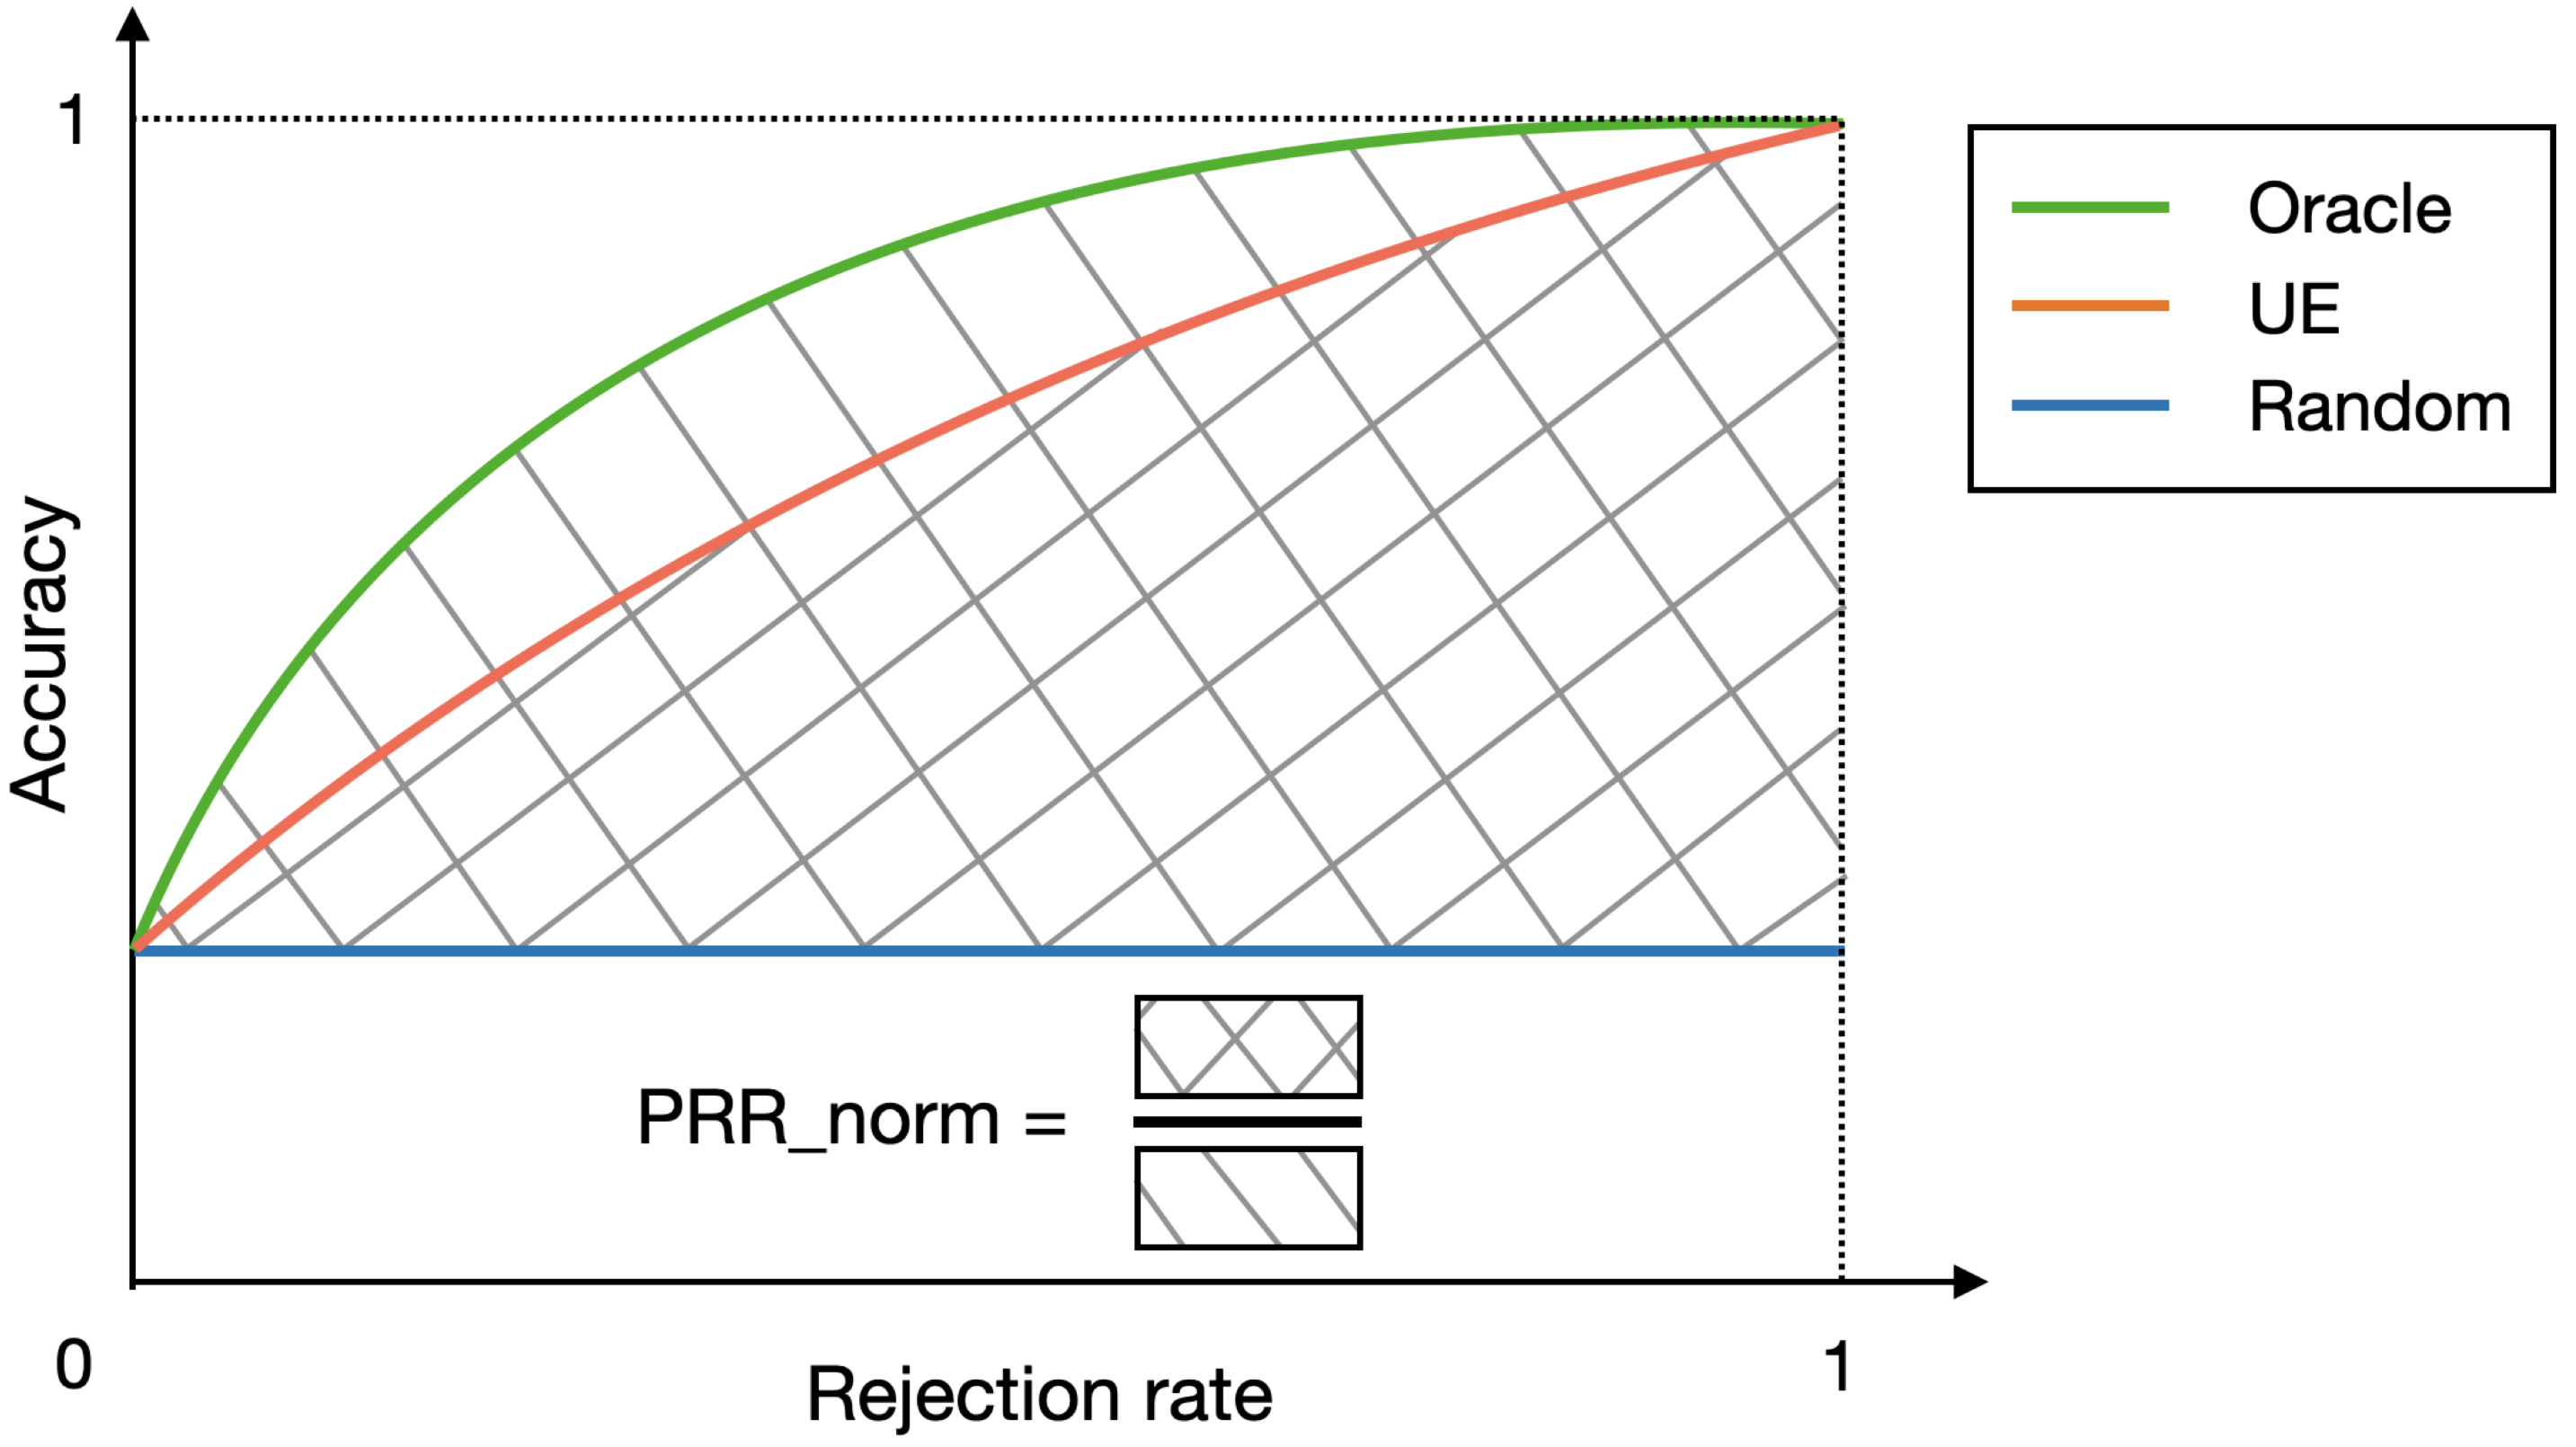

We won't need to do it ourselves, however, since Polygraph can do it for us.

In [ ]:
def get_prr(ue, acc):
    metric = PredictionRejectionArea()
    
    msp_prr = metric(ue, acc)
    oracle_prr = metric(-acc, acc)
    random_prr = get_random_scores(metric, acc)

    return normalize_metric(msp_prr, oracle_prr, random_prr)

In [ ]:
msp_norm_prr = get_prr(msp_ue, pointwise_accuracy)

print(msp_norm_prr)

This is quite high, so our MSP rejection is very close to oracle (which can be seen on rejection curves plot as well). Let's try this with other uncertainty estimation techinque.

### Mean Token Entropy

Recall, that LLM produces text sequences by predicting them one token at a time. This prediction happens by selecting the most probable token (or just sampling it) from the categorical distribution over token vocabulary. We can consider entropy of this distribution as model's uncertainty when selecting next token at this position. Averaged over all generated tokens, this gives us another way of quantifying sequence-level uncertainty:

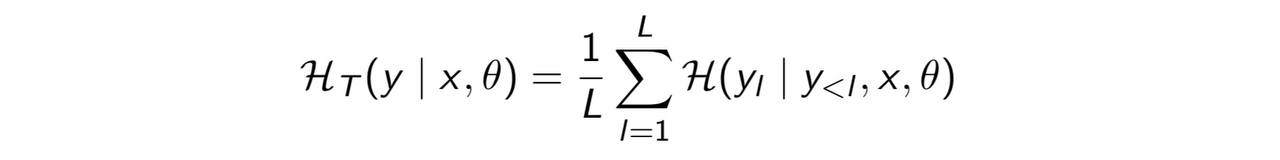

Now, use the functions that we defined earlier (`estimate_uncertainty`, `plot_rejection_curves` and `get_prr`) to estimate uncertainty using this approach and evaluate results, and then answer the questions below.

In [ ]:
estimator = MeanTokenEntropy()

# Use `estimate_uncertainty` function to get estimates
mte_ue = 

In [ ]:
# Use `plot_rejection_curves` to plot the, ehm, rejection curves

In [ ]:
# Use `get_prr` function to obtain normalized PRR value
mte_prr = 

print(mte_prr)

1) What is the approximate average accuracy at 50% coverage when rejecting data base on Mean Token Entropy estimate?
   

2) What is the value of normalized PRR for mean token entropy uncertainty estimates?
   

3) Which method is better for this model and data, MSP or MTE?



## Blackbox Uncertainty Estimation

Often, when working with SaaS LLM models (like GPT-4, Claude etc) you don't have access to the scores that the model assigns to tokens and sequences during generation, or have access to a limited slice of these statistics. Can we still estimate uncertainty when working with such black boxes?

In fact, we can. Recall, that models can sample tokens at each point in sequence generation. This implies, that two call to model's generate function can produce slightly different results even for identical inputs, if different seeds are set at the beginning.

We can then sample several `hypotheses` from the model using the same prompt, and look at how diverse these sequences are. If model generates wildly different responses to the same questions, it's probably not very certain it its response. On the other hand, if model is consistent in its generations, we can assume that it's quite certain. Let's try sampling 10 sequences for the first question in out dataset. 

In [ ]:
hypotheses = []

# Alternatively we could just pass `do_sample=True` and `num_return_sequences=10` to a single `model.generate()` call, but just to be consistent and ensure we don't go OOM on lab GPUs, let's do it caveman-style
for _ in range(10):
    input = chatify_and_tokenize(test_prompts[0])
    output = model.generate(**input, max_new_tokens=20)
    hypotheses.append(extract_answer(input, output))

print('Question: ', questions[0])
print(hypotheses)

Even with naked eye we can see that there's quite a bit of diversity in these samples. 

Now, if we introduce some sort of lexical equivalence function to measure similarity between this samples quantitatively, we can probably get a number that represents model's confidence. 

One such equivalence function is the Rouge metric. It measures similarity between two pieces of text based on the number of n-gram intersections. If we calculate average pairwise Rouge score between the samples, this number will tell us how similar the samples are, and we can use this as out uncertainty estimate.

Thus approach to UE is called LexicalSimilarity. Use the corresponding LM-Polygraph estimator, and our previously defined functions to calculate and analyze this method, as you did with MeanTokenEntropy.

In [ ]:
estimator = LexicalSimilarity('rougeL')

# Use `estimate_uncertainty` function to get estimate
lexsim_ue =

In [ ]:
# Use `plot_rejection_curves` to plot the, ehm, rejection curves

In [ ]:
# Use `get_prr` function to obtain normalized PRR value
lexsim_prr =

print(lexsim_prr)

1) What is the approximate average accuracy at 50% coverage when rejecting data base on Mean Token Entropy estimate?
   

2) What is the value of normalized PRR for mean token entropy uncertainty estimates?
   

3) Did you notice that this method took substantially more time to estimate uncertainty for our data? Why did that happen?

